# Modelagem do dataset Auto

Com o objetivo de praticar a análise exploratória dos dados e entender melhor os algoritmos supervisionados iremos analisar o dataset __Auto__ respondendo as questões do capítulo 4, exercício 11 do livro _An Introduction to Statistical Learning: with Applications in R._ 

Iremos, portanto, ao longo deste notebook realizar, principalmente, as seguintes atividades:

a) Binarizar a variável target. <br>
b) Análise descritiva dos dados. <br>
c) Dividir dataset em conjunto de treinamento e teste. <br>
d) Modelar o dataset com o algoritmo de análise discriminante linear e verificar seu erro. <br>
e) Modelar o dataset com o algoritmo de análise discriminante quadrático e verificar seu erro. <br>
f) Modelar o dataset com o algoritmo de regressão logística e verificar seu erro. <br>
g) Modelar o dataset com o algoritmo de vizinhos mais próximos e verificar seu erro.

Dataset disponível em: https://archive.ics.uci.edu/ml/datasets/auto+mpg <br>
Livro disponívek em: https://www.ime.unicamp.br/~dias/Intoduction%20to%20Statistical%20Learning.pdf

### Análise exploratória e pré-processamento

In [1]:
#Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
#Leitura do dataset
cars1 = pd.read_csv('auto-mpg.data',header=None,delim_whitespace=True,names = ['mpg','cylinders','displacement','horsepower','weight','acceleration','model_year','origin','car_name'], na_values = '?')

#Apresentando algumas linhas do dataset
cars1.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,car_name
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,ford torino


Segundo a documentação do dataset há Na valores, portanto, iremos identificá-los e tratá-los.

In [3]:
#Identificando atributos com Na valores
for col in cars1.columns:
    print(col,': ',cars1[col].isna().sum(),sep='')

mpg: 0
cylinders: 0
displacement: 0
horsepower: 6
weight: 0
acceleration: 0
model_year: 0
origin: 0
car_name: 0


In [4]:
#Substituir Na valores pela média no atributo horsepower
horsepower_mean = cars1['horsepower'].mean()
cars1['horsepower'] = cars1['horsepower'].map(lambda x: horsepower_mean if pd.isnull(x) else x)

#Fazendo a checagem da substituição
cars1['horsepower'].isna().sum()

0

In [5]:
#Checagem de tipos para verificar se os atributos estão todos corretamente tipados
cars1.dtypes

mpg             float64
cylinders         int64
displacement    float64
horsepower      float64
weight          float64
acceleration    float64
model_year        int64
origin            int64
car_name         object
dtype: object

In [6]:
#Apresentando algumas estatisticas
cars1.describe()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin
count,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000
mean,23.514573,5.454774,193.425879,104.469388,2970.424623,15.568090,76.010050,1.572864
std,7.815984,1.701004,104.269838,38.199187,846.841774,2.757689,3.697627,0.802055
min,9.000000,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000,1.000000
25%,17.500000,4.000000,104.250000,76.000000,2223.750000,13.825000,73.000000,1.000000
50%,23.000000,4.000000,148.500000,95.000000,2803.500000,15.500000,76.000000,1.000000
75%,29.000000,8.000000,262.000000,125.000000,3608.000000,17.175000,79.000000,2.000000
max,46.600000,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000,3.000000


Nós já iremos remover algumas variáveis do nosso dataset(pré-seleção) por acreditarmos que não serão interessantes em nosso modelo preditivo. Elas serão as seguintes:

1 - Model_year: Note pelas estatísticas descritivas que o ano dos modelos variam de 70 a 82. Caso essa variável seja utilizada não será possível, por exemplo, realizar a previsão de um carro do ano de 2018, pois não possuímos tais dados. <br>
2 - Origin: Da mesma forma que Model_year, será difícil obter tal informação quando analisarmos novos dados. Logo, iremos descartá-la.

Note em geral que estamos descartando tais variáveis, pois será difícil imputar tais valores para novas amostras. É muito mais fácil, por exemplo, obter o peso, número de cilindros, aceleração, etc.

In [7]:
#Pré-selecao das variaveis
cars2 = cars1.iloc[:,0:6].copy()
cars2.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration
0,18.0,8,307.0,130.0,3504.0,12.0
1,15.0,8,350.0,165.0,3693.0,11.5
2,18.0,8,318.0,150.0,3436.0,11.0
3,16.0,8,304.0,150.0,3433.0,12.0
4,17.0,8,302.0,140.0,3449.0,10.5


Boa parte dos algoritmos de classificação precisam que os dados sejam normalizados para melhor desempenho. Logo, iremos realizar uma normalização no intervalo [0,1].

In [8]:
#Normalizando
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
cars2.iloc[:,:] = min_max_scaler.fit_transform(cars2)

#Mostrando o dataset normalizado
cars2.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration
0,0.239362,1.0,0.617571,0.456522,0.536150,0.238095
1,0.159574,1.0,0.728682,0.646739,0.589736,0.208333
2,0.239362,1.0,0.645995,0.565217,0.516870,0.178571
3,0.186170,1.0,0.609819,0.565217,0.516019,0.238095
4,0.212766,1.0,0.604651,0.510870,0.520556,0.148810


### Binarização

In [9]:
#Binarizando a variável target por meio da mediana
mpg_median = cars2['mpg'].median()

cars2['mpg'] = cars2['mpg'].map(lambda x: 1 if x >= mpg_median else 0)

In [10]:
#Como agora temos duas classes, iremos verificar a quantidade de exemplos em cada uma delas (analisando desbalanceamento)
cars2.groupby('mpg').size()

mpg
0    197
1    201
dtype: int64

### Análise descritiva

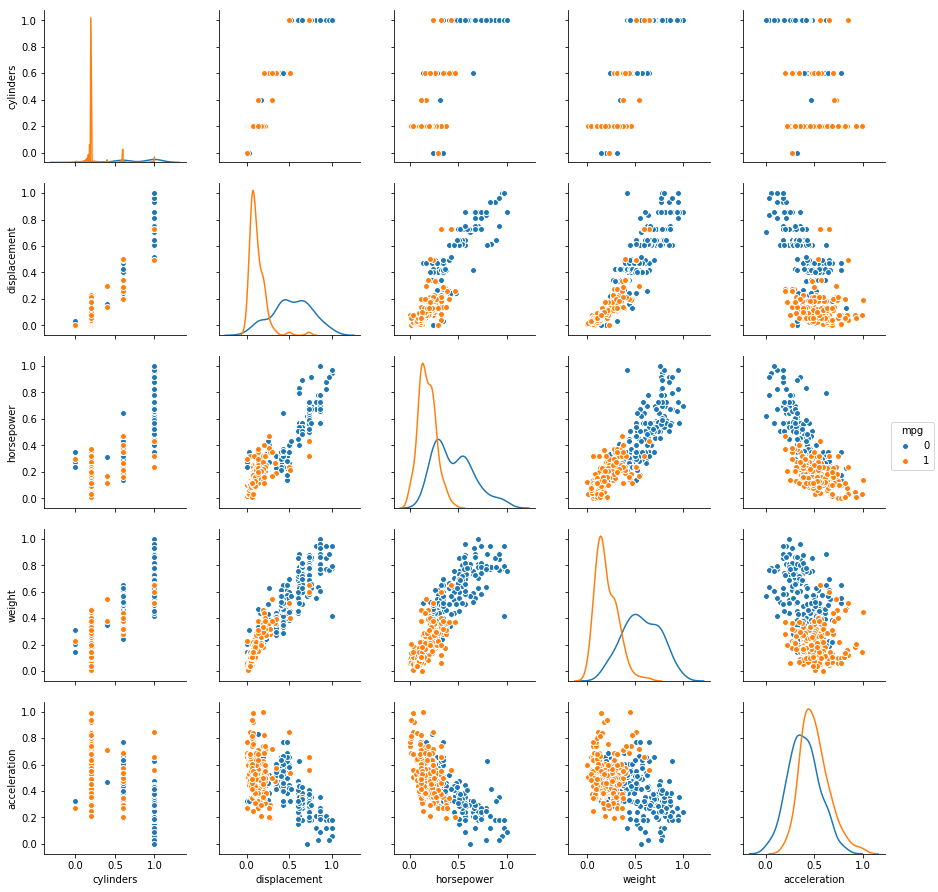

In [11]:
#Verificando a distribuição dos dados assim como suas relações
print('scatterplot por classe (aquisicao)')
sns.pairplot(cars2,hue='mpg',diag_kind='kde',vars=['cylinders','displacement','horsepower','weight','acceleration'])
plt.show()

print('scatterplot sem discriminação de classe')
sns.pairplot(cars2,hue='mpg',diag_kind='kde',vars=['cylinders','displacement','horsepower','weight','acceleration'])
plt.show()


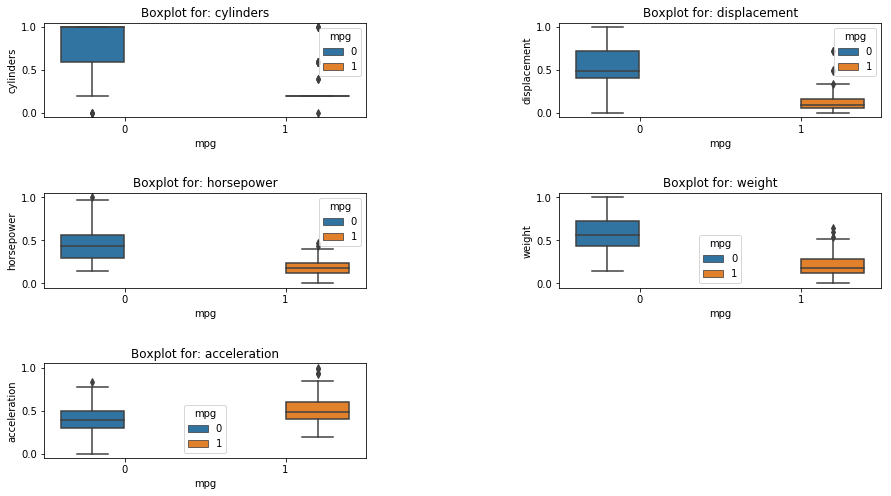

In [12]:
#Boxplot
plt.figure(figsize=(15,8))
plt.subplots_adjust(wspace=0.6,hspace=0.8)
for attribute,index in zip(cars2.columns,range(6)):
    if(attribute != 'mpg'):
        plt.subplot(3,2,index)
        plt.title('Boxplot for: ' + attribute)
        sns.boxplot(data=cars2[[attribute,'mpg']],x='mpg',y=attribute,hue='mpg')
plt.show()

Pela distribuição dos dados é possível verificar que __cylinders__ não é uma variável interessante pois há muitos exemplos da classe 1 e quase nenhum da classe 0. Tal fato iria enviesar nosso algoritmo. Assim, dado as variáveis restantes e os outros gráficos iremos escolher os atributos __displacement__ e __weight__ pelos seguintes motivos:

1 - Realizam uma separação razoável dos dados. <br> 
2 - Aparentam seguir uma normal (não há garantias de que é).

Esses dois fatores são algumas premissas que ajudam nossos modelos a terem melhores resultados. Além disso, foi realizada a escolha de apenas 2 variáveis, pois acreditamos que com elas já é possível explicar bem o modelo. Provavelmente a adição de mais atributos iria adicionar complexidade desnecessária ao modelo.

In [13]:
#Selecao de variaveis para modelagem
cars3 = cars2.iloc[:,[0,2,4]].copy()
cars3.head()

,mpg,displacement,weight
0,0,0.617571,0.536150
1,0,0.728682,0.589736
2,0,0.645995,0.516870
3,0,0.609819,0.516019
4,0,0.604651,0.520556


### Divisão do dataset em treino e teste

In [14]:
from sklearn.model_selection import train_test_split

#Split do dataset em treino(75%) e teste(25%)
X_train, X_test, y_train, y_test = train_test_split(cars3.iloc[:,1:3],cars3.iloc[:,0])

### Modelagem

Iremos modelar os algoritmos dos itens _d_ a _g_ e verificar seu erro médio quadrático.

In [15]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

#Criando modelos
lda = LinearDiscriminantAnalysis()
qda = QuadraticDiscriminantAnalysis()
lr = LogisticRegression()
_3nn = KNeighborsClassifier(n_neighbors = 3)
_5nn = KNeighborsClassifier(n_neighbors = 5)
_7nn = KNeighborsClassifier(n_neighbors = 7)
_9nn = KNeighborsClassifier(n_neighbors = 9)

#Lista com os classificadores
clfs = [lda,qda,lr,_3nn,_5nn,_7nn,_9nn]

#Lista com o nome dos classificadores
clfs_names = ['lda','qda','lrn','3nn','5nn','7nn','9nn']

In [16]:
from sklearn.metrics import accuracy_score

#Calculando erro médio quadrático de cada modelo
for name,c in zip(clfs_names,clfs):
    c.fit(X_train,y_train)
    y_predict = c.predict(X_test)
    print('Error for ',name,': ',np.round(1-accuracy_score(y_test,y_predict),2),sep='')

Error for lda: 0.1
Error for qda: 0.09
Error for lrn: 0.1
Error for 3nn: 0.09
Error for 5nn: 0.08
Error for 7nn: 0.08
Error for 9nn: 0.08


### Conclusão

Pelas análises e modelagem concluímos que apenas 2 atributos são necessários para gerar um bom modelo preditivo. Além disso, os algoritmos de classificação não aparentam possuir diferenças significativas entre eles quanto ao poder de generalização, ao menos até agora.